# Importing libraries and modules

In [1]:
import sys
directory_path = "../"
if directory_path not in sys.path:
    # Add the directory to sys.path
    sys.path.append(directory_path)
import os 
import copy
import time
import time
import numpy as np
import argparse

from random_graph import average_neighbor_weights

from torch.utils import data

from utils.utils import *
from utils import load_config
from utils.validate import *
from fedlearning.model import *
from fedlearning.dataset import *
from fedlearning.evolve import *
from fedlearning.optimizer import GlobalUpdater, LocalUpdater, get_omegas
from matplotlib import pyplot as plt
import pickle

import matplotlib.animation as animation
import seaborn as sns

In [2]:
config_file = "config_random_graph_st.yaml"
config = load_config(config_file)
logger = init_logger(config)
model = init_model(config, logger)
record = init_record(config, model)

if config.device == "cuda":
    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

current_path = os.getcwd()
if current_path.endswith("notebooks"):
    config.train_data_dir = "../" + config.train_data_dir
    config.test_data_dir = "../" + config.test_data_dir

--------------------------------------------------------------------------------


# Defining Plotting Functions 

In [3]:
def open_dat(fp):
    with open(fp, 'rb') as file:
        log = pickle.load(file)
        return log

def plot_acc_histogram(rec, dataset_name, round_num, save_path=None): 
    accs = np.array(rec["testing_accuracy"])[round_num]
    plt.hist(accs, bins = 20)
    if round_num == -1:
        round_num = len(rec["testing_accuracy"])-1
    plt.title(f"{dataset_name} Testing Accuracy Histogram: Round {round_num}")
    plt.xlabel("Accuracy")
    plt.ylabel("Client Frequency")

    if save_path is not None:
        plt.savefig(save_path)

    plt.show()

def get_acc_after_all_avg(rec, config, logger):
    # Only uses config to get the test_data and test_labels, so it only matters if the config
    # has the same test data, labels, and model as the one used in the experiment
    dataset = assign_user_data(config, logger)
    test_data = torch.from_numpy(dataset["test_data"]["images"]).to(config.device)
    test_labels = torch.from_numpy(dataset["test_data"]["labels"]).to(config.device)

    clients = list(rec["models"].keys())
    avged_weights = average_neighbor_weights(clients[0], clients[1:], rec["models"])
    test_model = init_model(config, logger)
    test_model.load_state_dict(avged_weights)
    output = test_model(test_data)
    return accuracy_with_output(output, test_labels)

def plot_acc_vs_round(rec, dataset_name, boxplot=False, median=False, 
                      save_path=None, config=None, logger=None, end_round=None):
    accs = np.array(rec["testing_accuracy"])[:end_round, :]
    print(accs.mean(axis=1))
    print(f"Max Acc: {accs.mean(axis=1).max()}")
    print(f"Final Acc: {accs.mean(axis=1)[-1]}")
    
    if config is not None and logger is not None:
        print(f"Acc after averaging all models: {get_acc_after_all_avg(rec, config, logger)}")
    
    rounds = np.arange(len(accs))
    plt.plot(rounds, accs.mean(axis=1), label="Mean", color="black")
    if boxplot:
        plt.boxplot(accs.T, positions=rounds, showfliers=False, medianprops=dict(color="red"))
    if median:
        plt.plot(rounds, np.median(accs, axis=1), label="Median", color="red")
    plt.title(f"{dataset_name} Average Testing Accuracy vs. Round")
    plt.xlabel("Communication Round")
    plt.xticks(np.arange(0, len(accs)+1, 3), np.arange(0, len(accs)+1, 3))
    plt.ylabel("Accuracy")
    plt.legend()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

def save_results_intxt(rec, dataset_name, save_path, config, logger, round=None):
    accs = np.array(rec["testing_accuracy"])
    with open(save_path, "w") as file:
        file.write(f"Dataset: {dataset_name}\n")
        file.write(f"Topology: {rec["topology"]}\n")
        if round is None: 
            file.write(f"Max Acc: {accs.mean(axis=1).max()}\n")
        else: 
            file.write(f"Max Acc: {accs.mean(axis=1)[:round].max()}\n")
        file.write(f"Final Acc: {accs.mean(axis=1)[-1]}\n")
        file.write(f"Final Acc After All Models are Averaged: {get_acc_after_all_avg(rec, config, logger)}\n")
        file.write(f"Rounds: {rec["epoch"]}\n")

def all_save(rec, dataset_name, save_path, config, logger, boxplot=False, median=False):
    plot_acc_vs_round(rec, dataset_name, boxplot=boxplot, median=median, save_path=save_path+"_acc.png")
    plot_acc_histogram(rec, dataset_name, -1, save_path=save_path+"_hist.png")
    save_results_intxt(rec, dataset_name, save_path+"_results.txt", config, logger)

# def plot_accs()

In [4]:
def plot_multiple_accs(fps, labels, title=None, save_path=None, y_lim=None, common_x=True):
    recs_to_compare = [open_dat(fp) for fp in fps]
    
    xs = np.arange(min(
        [len(rec["testing_accuracy"]) for rec in recs_to_compare]
    ))
    length = xs.shape[0]

    for i in range(len(recs_to_compare)):
        if common_x: 
            plt.plot(xs, np.array(recs_to_compare[i]["testing_accuracy"]).mean(axis=1)[:length], label=labels[i])
        else: 
            plt.plot(np.array(recs_to_compare[i]["testing_accuracy"]).mean(axis=1), label=labels[i])

    plt.xlabel("Communication Round")
    plt.ylabel("Accuracy")
    if title == None: 
        plt.title("Comparison of Self-Training Strategies")
    else: 
        plt.title(title)
    plt.legend()
    if y_lim is not None:
        plt.ylim(y_lim)
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

# filepaths_to_cmpr = ["/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial8/19_06_04_26.dat",
#                             "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial10/oneround20_06_16_55.dat",
#                                 "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial9/allrounds21_06_02_32.dat"]
# labels = ["No self-training", "One round self-training", "All round self training"]
# plot_multiple_accs(filepaths_to_cmpr, labels, save_path=None, common_x=False)

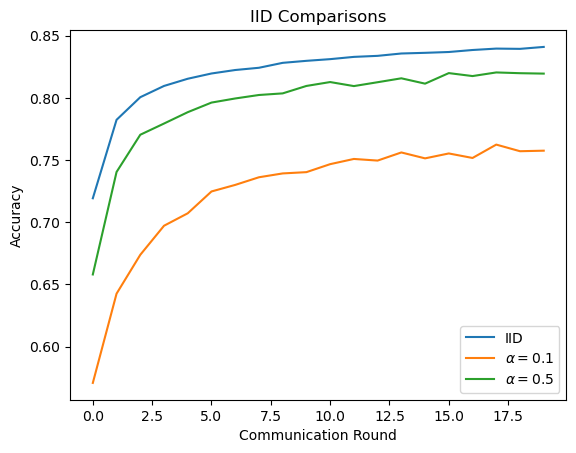

In [37]:
fps_to_cmpr = ["../records/trial1/17_06_15_56.dat", 
                     "../records/trial2/14_06_01_57.dat",
                    "../records/trial3/24_06_04_45.dat"]
labels = ["IID", r"$\alpha=0.1$", r"$\alpha=0.5$"]
plot_multiple_accs(fps_to_cmpr, labels, save_path=None, title="IID Comparisons")

Max Acc: 0.8282573135693868
Final Acc: 0.826691979765892
Acc after averaging all models: 0.863099992275238


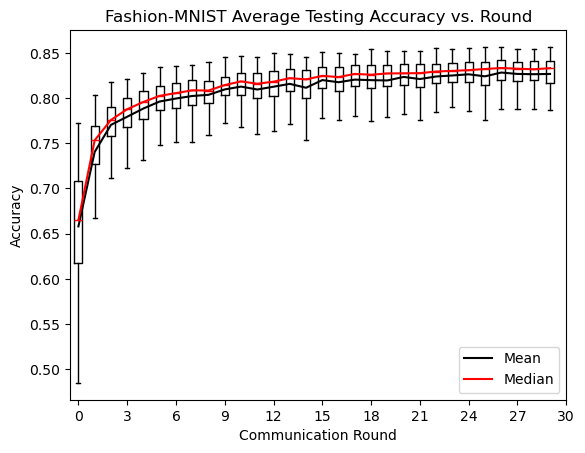

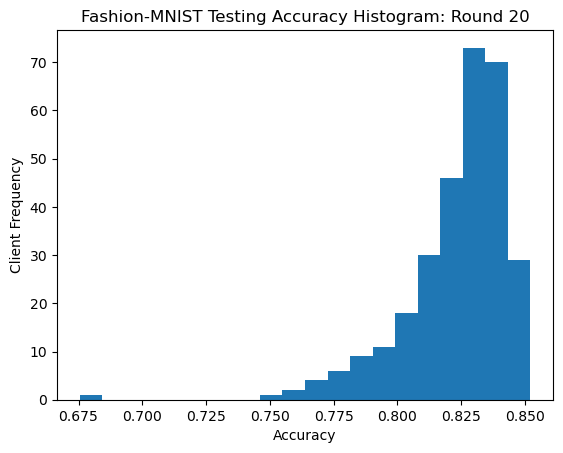

In [6]:
fp_temp = "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial3/24_06_04_45.dat"
rec_temp = open_dat(fp_temp)
plot_acc_vs_round(rec_temp, "Fashion-MNIST", boxplot=True, median=True, config=config, logger=logger, 
                  save_path="/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial3/trial3_acc.png")
plot_acc_histogram(rec_temp, "Fashion-MNIST", 20, save_path="/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial3/trial3_hist.png")
save_results_intxt(rec_temp, "Fashion-MNIST", f"../records/trial3/trial3_results.txt", config, logger)


Max Acc: 0.8293889786799749
Final Acc: 0.8293889786799749


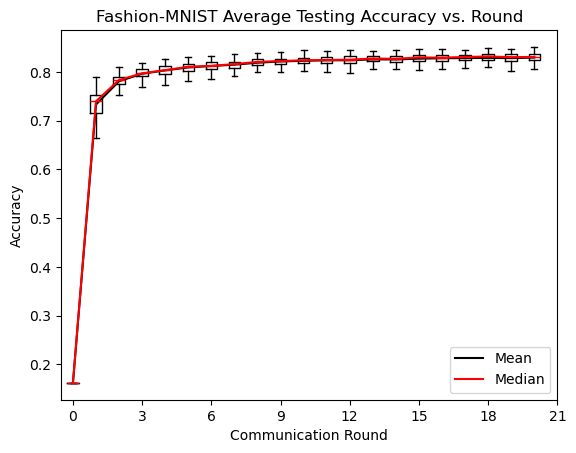

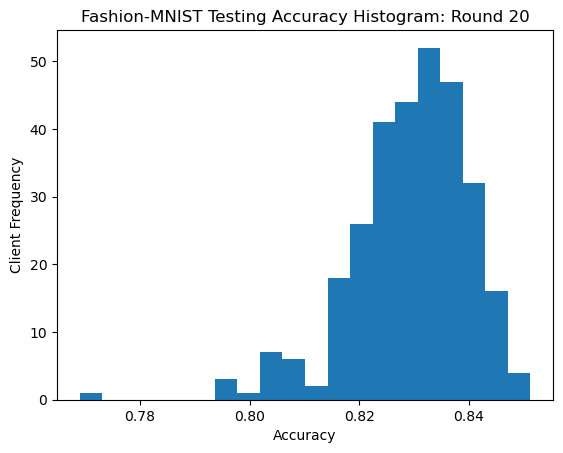

Max Acc: 0.831642644405365
Final Acc: 0.8312366443872452


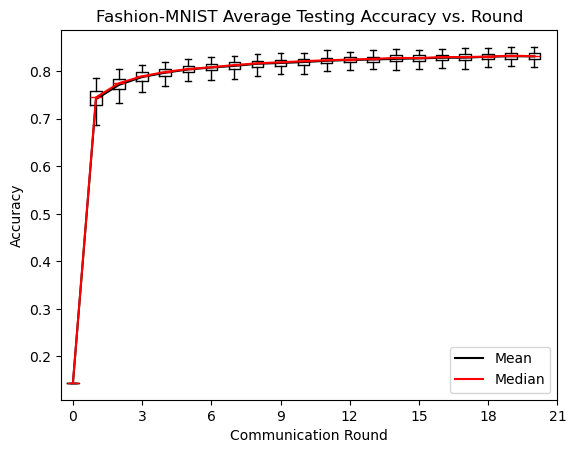

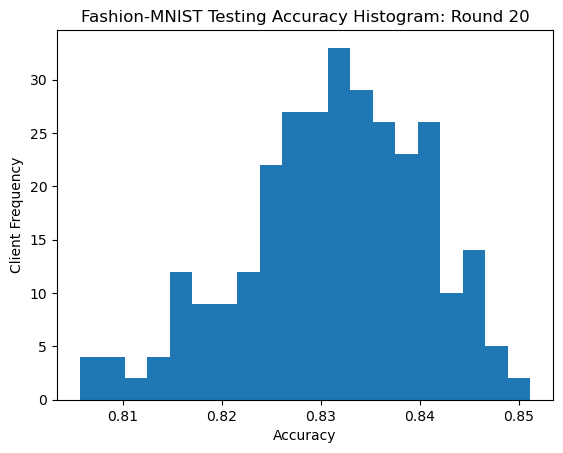

Max Acc: 0.840665978193283
Final Acc: 0.840665978193283


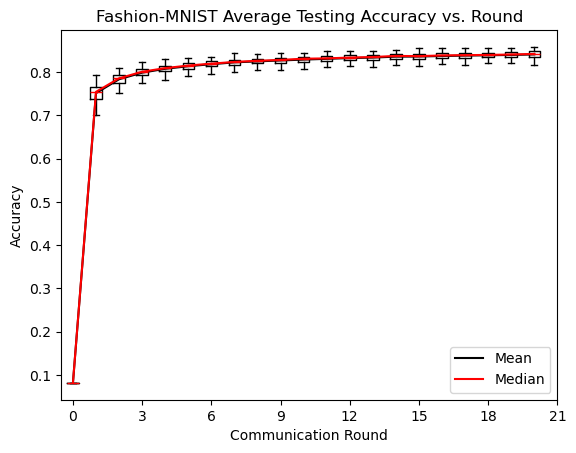

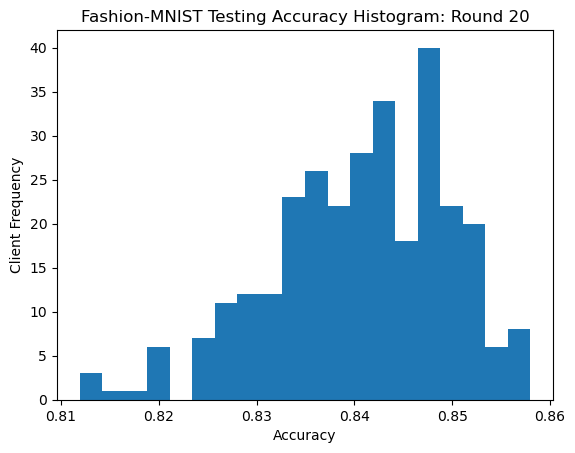

Max Acc: 0.8379099788268407
Final Acc: 0.8379099788268407


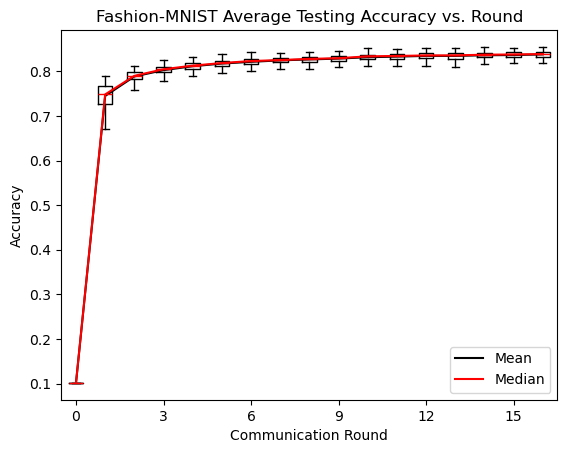

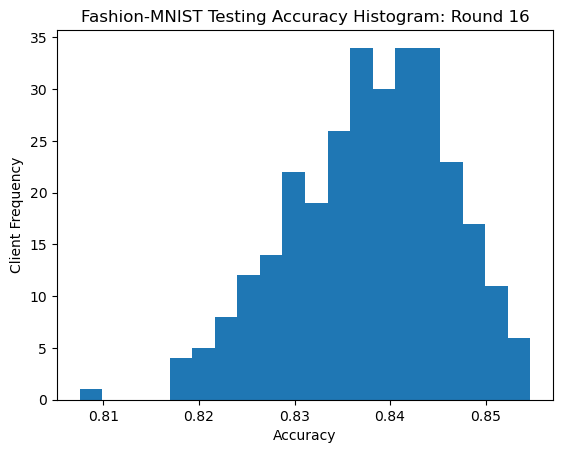

In [11]:
root = "../records"
filepaths = [
    "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial9/allrounds21_06_02_32.dat",
    "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial10/oneround20_06_16_55.dat",
    "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial11/oneround23_06_00_32.dat",
    "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/records/trial12/allround23_06_18_02.dat"
]
recs = [open_dat(fp) for fp in filepaths]

for i, rec in enumerate(recs, 9):
    plot_acc_vs_round(rec, "Fashion-MNIST", boxplot=True, median=True, save_path=f"../records/trial{i}/trial{i}_acc.png")
    plot_acc_histogram(rec, "Fashion-MNIST", -1, save_path=f"../records/trial{i}/trial{i}_hist.png")
    save_results_intxt(rec, "Fashion-MNIST", f"../records/trial{i}/trial{i}_results.txt", config, logger)



# for rec in recs:
#     plot_acc_vs_round(rec, "Fashion-MNIST", boxplot=True, median=True, config=config, logger=logger)
#     plot_acc_histogram(rec, "Fashion-MNIST", -1)

(array([ 300.,    0., 2163.,    0.,    0., 2966.,    0., 1788.,    0.,
           0.,  923.,    0.,  440.,    0.,    0.,  354.,    0.,    0.,
           0.,  366.]),
 array([ -1.  ,  39.05,  79.1 , 119.15, 159.2 , 199.25, 239.3 , 279.35,
        319.4 , 359.45, 399.5 , 439.55, 479.6 , 519.65, 559.7 , 599.75,
        639.8 , 679.85, 719.9 , 759.95, 800.  ]),
 <BarContainer object of 20 artists>)

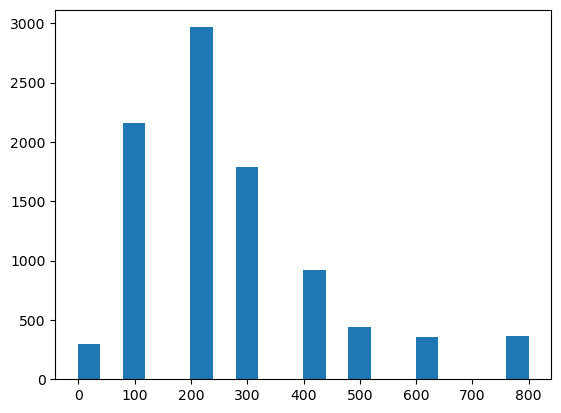

In [52]:
plt.hist(np.array(rec["taus"]).flatten(), bins=20)

Animation.save using <class 'matplotlib.animation.HTMLWriter'>
Animation.save using <class 'matplotlib.animation.HTMLWriter'>
Animation.save using <class 'matplotlib.animation.HTMLWriter'>
Animation.save using <class 'matplotlib.animation.HTMLWriter'>
Animation.save using <class 'matplotlib.animation.HTMLWriter'>
Animation.save using <class 'matplotlib.animation.HTMLWriter'>


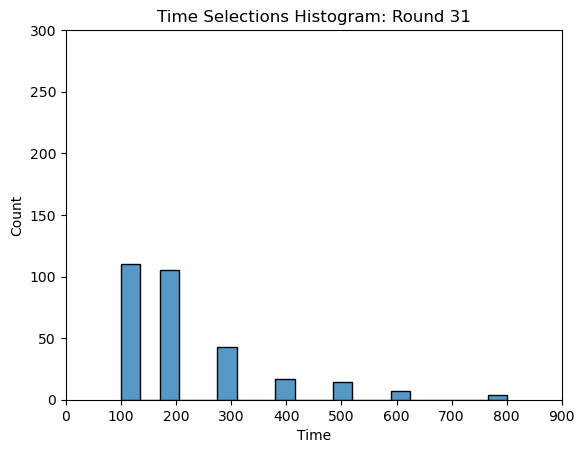

In [87]:
def plot_taus_over_time(rec):
    from IPython.display import HTML
    %matplotlib inline
    # Assuming `data` is a 2D list or numpy array where rows are rounds and columns are t values of clients
    data = np.array(rec["taus"] )
    max_tau = data.max()
    fig, ax = plt.subplots()
    def update_hist(num, data):
        ax.clear()
        sns.histplot(data[num, :], bins=20, kde=False, ax=ax)
        ax.set_title(f'Time Selections Histogram: Round {num+1}')
        ax.set_xlim(data.min(), data.max())
        ax.set_ylim(0, 300)  # Adjust as necessary based on your data
        ax.set_xlim(0, max_tau+100)
        ax.set_xlabel("Time")
    ani = animation.FuncAnimation(fig, update_hist, frames=range(data.shape[0]), fargs=(data,), repeat=False)
    return HTML(ani.to_jshtml())

plot_taus_over_time(recs[7])

In [5]:
fp = "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/lr0.01/alpha0.5.dat"
rec = open_dat(fp)
rec["testing_accuracy"]

[0.6532999873161316,
 0.7224999666213989,
 0.7925999760627747,
 0.7913999557495117,
 0.8163999915122986,
 0.8168999552726746,
 0.8184999823570251,
 0.823199987411499,
 0.8233000040054321,
 0.8366000056266785,
 0.8328999876976013,
 0.8283999562263489,
 0.8341999650001526,
 0.8424999713897705,
 0.8387999534606934,
 0.836899995803833,
 0.8434000015258789,
 0.8393999934196472,
 0.8411999940872192,
 0.8410999774932861]

In [12]:
main_st_fps = {
    0.5: "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/st_main_1/26_06_11_03.dat", # 0.5
    0.1: "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/st_main_2/26_06_11_31.dat", # 0.1
    -1: "/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/st_main_3/26_06_12_09.dat" # IID
}

main_st_recs = {alpha: open_dat(fp) for alpha, fp in main_st_fps.items()}

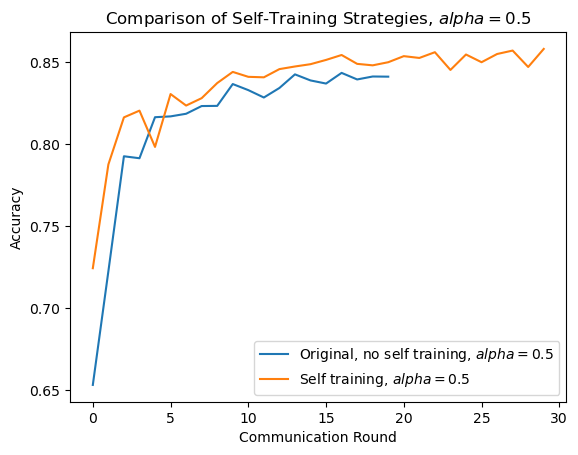

In [19]:
original_alpha05 = open_dat("/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/lr0.01/alpha0.5.dat")
plt.plot(original_alpha05["testing_accuracy"], label = "Original, no self training, $alpha=0.5$")
plt.plot(main_st_recs[0.5]["testing_accuracy"], label="Self training, $alpha=0.5$")
plt.title("Comparison of Self-Training Strategies, $alpha=0.5$")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.legend()

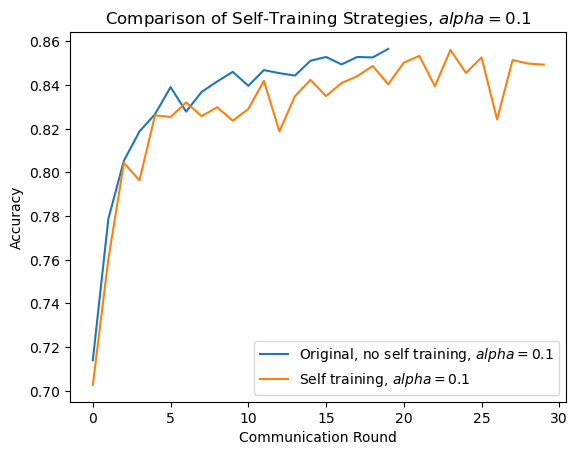

In [20]:
original_alpha01 = open_dat("/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/lr0.01/alpha0.1.dat")
plt.plot(original_alpha01["testing_accuracy"], label = "Original, no self training, $alpha=0.1$")
plt.plot(main_st_recs[0.1]["testing_accuracy"], label="Self training, $alpha=0.1$")
plt.title("Comparison of Self-Training Strategies, $alpha=0.1$")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.legend()

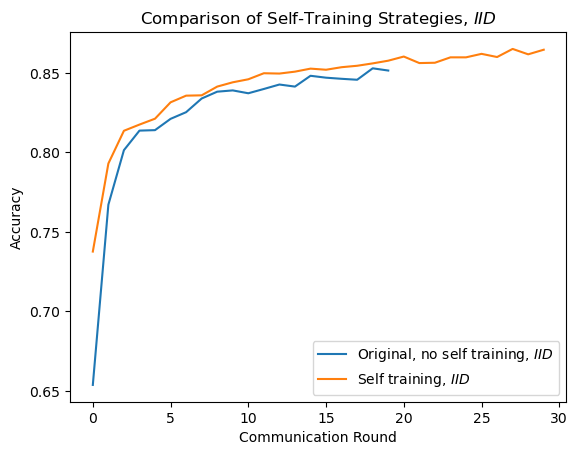

In [21]:
original_alpha01 = open_dat("/home/gathomp3/Deep_Learning/NeuralTangent/ntk-fed/utils/results/replication/iid_FAMNIST.dat")
plt.plot(original_alpha01["testing_accuracy"], label = "Original, no self training, $IID$")
plt.plot(main_st_recs[-1]["testing_accuracy"], label="Self training, $IID$")
plt.title("Comparison of Self-Training Strategies, $IID$")
plt.xlabel("Communication Round")
plt.ylabel("Accuracy")
plt.legend()

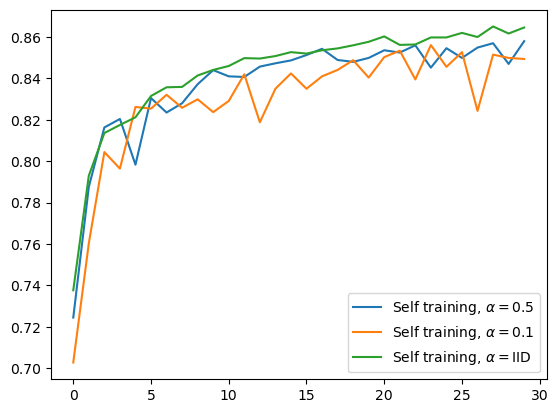

In [24]:
plt.plot(main_st_recs[0.5]["testing_accuracy"], label=r"Self training, $\alpha=0.5$")
plt.plot(main_st_recs[0.1]["testing_accuracy"], label=r"Self training, $\alpha=0.1$")
plt.plot(main_st_recs[-1]["testing_accuracy"], label=r"Self training, $\alpha=\text{IID}$")
plt.legend()
plt.show()

[0.11009999 0.64595798 0.70572832 0.72882932 0.74655565 0.75563098
 0.76132231 0.76459965 0.76918331 0.77269831 0.77945531 0.77952098
 0.78183565 0.78206131 0.78643431 0.78712831 0.78882398 0.78873431
 0.79139598 0.79443365 0.79456598]
Max Acc: 0.7945659806330999
Final Acc: 0.7945659806330999
Acc after averaging all models: 0.85589998960495


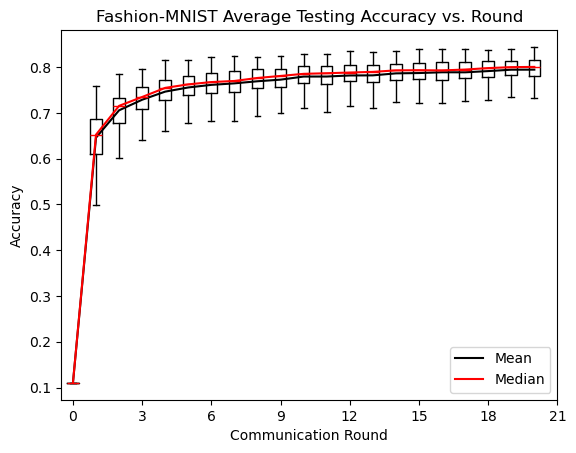

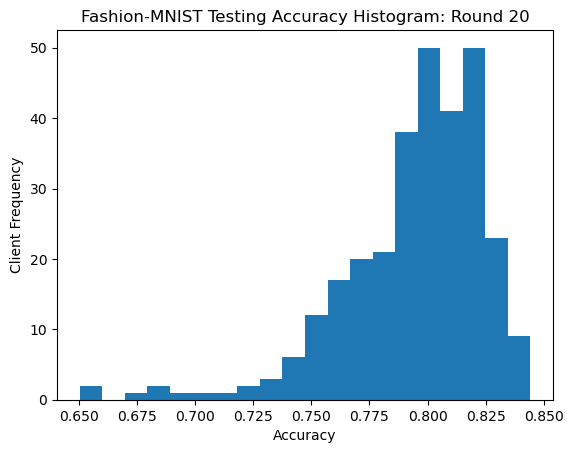

In [52]:
fp = "../../records/trial13/27_06_01_23.dat"
rec = open_dat(fp)
# plot_acc_vs_round(rec, "Fashion-MNIST", boxplot=True, median=True, config=config, logger=logger, save_path="../../records/trial13/trial13_acc.png")
# plot_acc_histogram(rec, "Fashion-MNIST", -1, save_path="../../records/trial13/trial13_hist.png")
# save_results_intxt(rec, "Fashion-MNIST", f"../../records/trial13/trial13_results.txt", config, logger)

[0.0635     0.67123265 0.74370598 0.76812031 0.78235798 0.78792998
 0.79675631 0.79957798 0.80472331 0.80540731 0.80661298 0.81091731
 0.81388098 0.81283598 0.81771865 0.81483598 0.81620731 0.81859431
 0.82001198 0.82233298 0.82336331 0.82138998 0.82257598 0.82498898
 0.82556598 0.82490898 0.82680165 0.82651998 0.82718198 0.82869865
 0.82949831]
Max Acc: 0.8294983114798864
Final Acc: 0.8294983114798864
Acc after averaging all models: 0.8618999719619751


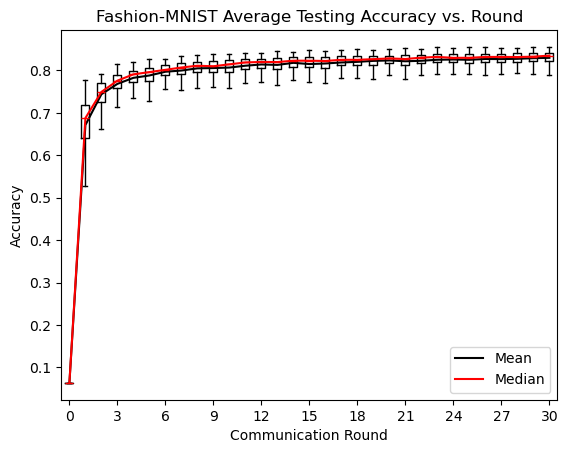

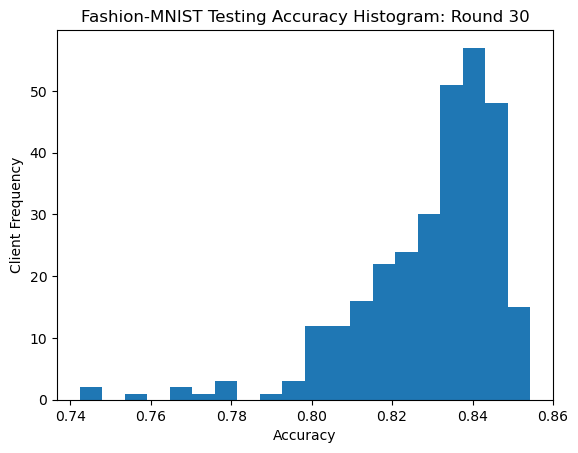

In [53]:
fp = "/home/gathomp3/Deep_Learning/NeuralTangent/records/trial14/28_06_07_16.dat"
rec = open_dat(fp)
plot_acc_vs_round(rec, "Fashion-MNIST", boxplot=True, median=True, config=config, logger=logger, save_path="../../records/trial14/trial14_acc.png")
plot_acc_histogram(rec, "Fashion-MNIST", -1, save_path="../../records/trial14/trial14_hist.png")
save_results_intxt(rec, "Fashion-MNIST", f"../../records/trial14/trial14_results.txt", config, logger)

In [35]:
config_file = "config_random_graph_st.yaml"
config = load_config(config_file)
logger = init_logger(config)
model = init_model(config, logger)
record = init_record(config, model)

if config.device == "cuda":
    torch.backends.cudnn.benchmark = True
    # torch.backends.cudnn.deterministic = True

current_path = os.getcwd()
if current_path.endswith("notebooks"):
    config.train_data_dir = "../" + config.train_data_dir
    config.test_data_dir = "../" + config.test_data_dir

get_acc_after_all_avg(rec, config, logger)

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


0.8618999719619751

In [24]:
np.array(rec["testing_accuracy"])[1:, :]

array([[0.68540001, 0.51569998, 0.71649998, ..., 0.66969997, 0.6839    ,
        0.69389999],
       [0.71630001, 0.64249998, 0.77359998, ..., 0.69839996, 0.73219997,
        0.73009998],
       [0.74759996, 0.66149998, 0.7723    , ..., 0.73519999, 0.7001    ,
        0.76639998],
       ...,
       [0.82999998, 0.74119997, 0.81689996, ..., 0.76879996, 0.78539997,
        0.8258    ],
       [0.82249999, 0.7489    , 0.83039999, ..., 0.8035    , 0.80369997,
        0.82179999],
       [0.82919997, 0.75629997, 0.79629999, ..., 0.8233    , 0.81819999,
        0.81709999]])

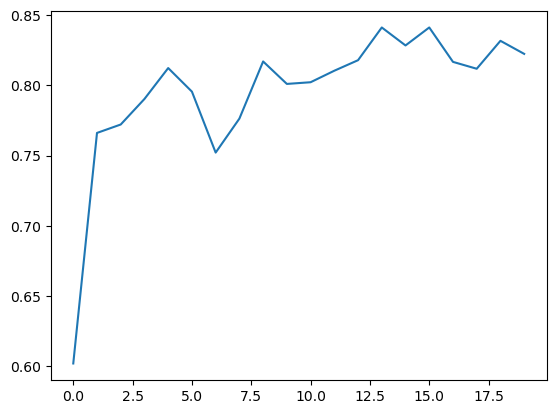

In [33]:
plt.plot(np.array(rec["pre_sgd_acc"])[:,4])